1. Построить признаки на основе [данного](http://study.mokoron.com/) корпуса. Самый простой способ - удалить пунктуацию, лемматизировать и закодировать слова `CountVectorizer`.
1. Оценить время работы K-Means, иерархической кластеризации и EM-алгоритма. Если слишком долго - брать подвыборки.
1. Попробовать "нащупать" оптимальное число кластеров. Для этого можно воспользоваться следующими подходами:
    1. Визуально смотреть, насколько тексты в одном кластере похожи друг на друга и не похожи на другие. Для этого построить словарь самых частых слов.
    1. Воспользоваться метрикой силуэта, пример: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
    1. Посмотреть в каком месте столбцы linkage начинают резко расти
1. Дополнительно для linkage посмотреть структуры кластеров от 1 до 10 и попытаться понять, есть ли в этом логика :)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter
import random

In [2]:
column_names = ['id', 'tdate', 'tname', 'ttext', 'ttype', 'trep', 'trtw', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']
df_positive = pd.read_csv('data/tweets/positive.csv', delimiter=';', names=column_names, index_col='id')
df_negative = pd.read_csv('data/tweets/negative.csv', delimiter=';', names=column_names, index_col='id')

In [3]:
df_positive.head()

,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
id,,,,,,,,,,,
408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1


In [4]:
df_negative.head()

,tdate,tname,ttext,ttype,trep,trtw,tfav,tstcount,tfol,tfrien,listcount
id,,,,,,,,,,,
408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0


In [5]:
usecols = ['ttext']
df = pd.concat((df_positive[usecols], df_negative[usecols])).sample(frac=1, random_state=42).reset_index(drop=True)
texts = df['ttext'].copy()
del df
del df_positive
del df_negative

In [6]:
texts.head()

0    мыс на меня обиделась:(\nя ей даже ничего не с...
1            аааааааааааааааааааа,не хочу на работу :(
2    У меня какой-то особенный вид ушей! :D, некото...
3    @simonovkon  он неплохой человек в жизни. Я ра...
4    RT @Darina_Lo: Домааааа\nЕхали на такси, пели ...
Name: ttext, dtype: object

# 1. Preprocessing

In [7]:
from pymystem3 import Mystem
stemmer = Mystem()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian') + stopwords.words('english'))

import re
sentence_ending = re.compile(r"[.?!\n]+")
whitespace_characters = re.compile(r"[\s_\-]+")
email = re.compile(r"\w+([-+.']\w+)*@\w+([-.]\w+)*\.\w+([-.]\w+)*")
url = re.compile(r"http[s]?:\/\/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
username = re.compile(r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9-_]+)")
to_drop = re.compile(r"\d")
allowed_tokens = re.compile(r"[\w-]+|\.")

[nltk_data] Downloading package stopwords to /home/nik7/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def process(string):
    string = string.lower()
    string = re.sub(email, ' EMAIL ', string)
    string = re.sub(url, ' URL ', string)
    string = re.sub(username, ' USERNAME ', string)
    string = re.sub(sentence_ending, '.', string)
    string = re.sub(whitespace_characters, ' ', string)
    string = re.sub(to_drop, ' ', string)
    string = re.sub(r"(.)\1{3,}", r"\1\1\1", string) # replace characters repeated more than 3 times
    string = ' '.join(re.findall(allowed_tokens, string))
    string = ''.join(stemmer.lemmatize(string))
    string = string.strip()
    return string

In [9]:
%%time
processed_texts = texts.apply(process)

CPU times: user 39.4 s, sys: 3.07 s, total: 42.4 s
Wall time: 2min 43s


In [10]:
processed_texts.head()

0     мыс на я обижаться . я она даже ничто не сделать
1                              ааа не хотеть на работа
2    у я какой то особенный вид ухо . d некоторый в...
3    USERNAME он неплохой человек в жизнь . я работ...
4    rt USERNAME домааа . ехать на такси петь песня...
Name: ttext, dtype: object

Всего твитов:

In [11]:
processed_texts.shape

(226834,)

Всего слов:

In [12]:
word_counts = Counter(np.concatenate(processed_texts.str.split(' ').values))
sum(word_counts.values())

2987990

Всего уникальных слов:

In [13]:
len(word_counts)

104510

Средняя частота слова:

In [14]:
sum(word_counts.values()) / len(word_counts)

28.590469811501293

Средняя длина твита:

In [15]:
sum(word_counts.values()) / processed_texts.shape[0]

13.17258435684245

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
vectorizer = TfidfVectorizer()
data = vectorizer.fit_transform(processed_texts)

In [18]:
data.shape

(226834, 104426)

In [19]:
from sklearn.decomposition import TruncatedSVD

In [20]:
%%time
reduced_texts = texts.sample(20000) 
reduced_texts_processed = reduced_texts.apply(process)
reduced_data = vectorizer.transform(reduced_texts_processed)
svd = TruncatedSVD(n_components=100, n_iter=5, random_state=42)
reduced_data = svd.fit_transform(reduced_data)

CPU times: user 27.4 s, sys: 14.9 s, total: 42.3 s
Wall time: 21.9 s


# 2. Time benchmark

## K-means

In [21]:
from sklearn.cluster import KMeans

In [22]:
model = KMeans(n_jobs=4, random_state=42)

In [23]:
%%time
model.fit(reduced_data)

CPU times: user 65.2 ms, sys: 76.6 ms, total: 142 ms
Wall time: 3.65 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=4, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [24]:
model.inertia_

3285.98696951545

## Hierarchy

In [25]:
from sklearn.cluster import AgglomerativeClustering

In [26]:
model = AgglomerativeClustering()

In [27]:
%%time
model.fit(reduced_data)

CPU times: user 37.1 s, sys: 1.49 s, total: 38.6 s
Wall time: 38.5 s


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

## EM-algorithm / GaussianMixture

In [28]:
from sklearn.mixture import GaussianMixture

In [29]:
model = GaussianMixture(n_components=10)

In [30]:
%%time
model.fit(reduced_data)

CPU times: user 3min 24s, sys: 1min 51s, total: 5min 16s
Wall time: 58.3 s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

# 3. Optimal cluster count

## K-means

### A. Визуально смотреть, насколько тексты в одном кластере похожи друг на друга и не похожи на другие. Для этого построить словарь самых частых слов.

In [31]:
def SampleKMeans(n_clusters, most_common, n_samples, random_state):
    model = KMeans(n_clusters=n_clusters, n_jobs=4, random_state=random_state)
    model.fit(reduced_data)
    labels = model.predict(svd.transform(data))
    for label in range(n_clusters):
        print(f'CLUSTER {label}:')
        print(f'{sum(labels == label)} samples')
        top_words = Counter(np.concatenate(processed_texts[labels == label].str.split(" ").values)).most_common(most_common + len(stop_words))
        top_words = [word for (word, count) in top_words if word not in stop_words]
        print(f'Most common words: {" ".join(top_words[:most_common])}')
        print('Sample tweets:')
        print()
        for text in texts[labels == label].sample(n_samples, random_state=random_state):
            print('==================================================')
            print(text)
            print('==================================================')
            print()

Видно, что первый кластер, который отделяется - это ретвиты:

In [32]:
SampleKMeans(2, 20, 5, 42)

CLUSTER 0:
33143 samples
Most common words: USERNAME rt . URL это день спасибо хотеть весь любить сегодня очень хороший знать год просто новый мочь самый свой
Sample tweets:

RT @NastaCerepanova: Моя самая любимая фотка Френка. Тут он такой счастливый :) и улыбка у него *О* http://t.co/5VBUQBZwCz

@heeeeey_watson твой юп тут :D http://t.co/ylSSnSHTKm

RT @Alexey_Andronov: Бггггг :) “@fratria: @Alexey_Andronov тогда уж так :) "Российский футбол": http://t.co/0pVGCZIvef”

RT @aaamir7: @OrdaFM на самом деле, это очень символично. Слушать местное радио на местной Камри )

RT @yvycacolyg: Хочу третий сезон Волчицы и Меланхолии. :)

CLUSTER 1:
193691 samples
Most common words: . USERNAME URL это rt весь хотеть день сегодня мочь очень знать просто год человек любить свой завтра новый вообще
Sample tweets:

@Live_For_Zayn Ох, конечно, держи;) хх http://t.co/TgPovl9E1q

@hardparty_yeah было неплохо, пока не узнала, что у меня за кр по физике 6(((((( очень красивые оценки: 10-11-10-10-10-11-10-1

Видно, что при большем количестве кластеров ретвиты продолжают выделяться в отдельный кластер, остальные кластеры сложнее интерпретировать из-за обилия стоп-слов

In [33]:
SampleKMeans(10, 20, 5, 42)

CLUSTER 0:
16651 samples
Most common words: . USERNAME это rt URL весь хотеть мочь день сегодня знать человек очень вообще почему просто делать думать любить год
Sample tweets:

@BOBA_KOT что,то снилось,а что не помню,как всегда!( но зато помню что мне снилось в прошлом году,все норм

@Terachi_Shinya_ а если бы читал то мои мысли бы боялся прочесть ахаахха
Или перешел в другую ориентацию пахахахах ))

Если кто-то ищет выгоды для себя в отношениях, то это не любовь, просто один искренне любит а другой позволяет любить.вот сука какая любовь(

Фу! почему-то много гомосексуалистов стала видеть,и много слышать про них!!((куда катится мир!

У моей крошки что то случилось( она звонила!!

CLUSTER 1:
102397 samples
Most common words: . USERNAME это весь хотеть день сегодня rt мочь очень просто знать год человек свой завтра вообще новый блин спать
Sample tweets:

Отказываюсь от водки Финляндия!!! Ребята, ну что же вы так(

В твиттере тишина, в контакте тишина, ребят, вы где все? ;(

я по вам тут

18819 samples
Most common words: URL . USERNAME это день новый год хотеть весь сегодня очень rt свой любить утро спасибо самый любимый мочь друг
Sample tweets:

Ну.. если вы понимаете о чем я х))) 
http://t.co/X66x6dysiV

Кто проспал молодёжку?  - яяя:( http://t.co/peMfgcqwYF

Доброе утро, #twiby! Вот теперь ощущается зима...подмораживает! ;) #belarus http://t.co/tyUzYsAmZZ

Новая учительница по физике задала домашки больше чем нам за все полугодие задали раньше((( http://t.co/lQzShN9WC6

Оставила Владюше телефон на хореографии. Увидела вот это! Закружила :D http://t.co/ReC54mm3CB

CLUSTER 9:
5011 samples
Most common words: USERNAME . rt это URL спасибо знать весь хотеть очень любить привет вообще понимать ахах снаступающимтвиттерский добрый день блин просто
Sample tweets:

RT @_2777489098552: @Z8SS @SPB_citizen Да,если...!:-))) http://t.co/YpEagErNHM

@akikomiyim @kompashka @olyapka я в зоомагазине покупала)

@Olga_Vivina @windrty @antipn @volodya_Kharkov @zero_home Может и есть...под

### B. Воспользоваться метрикой силуэта

For n_clusters = 2 The average silhouette_score is : 0.08156891316091006
For n_clusters = 3 The average silhouette_score is : 0.07713022875234236
For n_clusters = 4 The average silhouette_score is : 0.04953559867064901
For n_clusters = 5 The average silhouette_score is : 0.01781204924264003
For n_clusters = 6 The average silhouette_score is : 0.014861107775084707
For n_clusters = 8 The average silhouette_score is : 0.023807474645268174
For n_clusters = 10 The average silhouette_score is : 0.017422591504370557
For n_clusters = 12 The average silhouette_score is : 0.021442834387766407
For n_clusters = 15 The average silhouette_score is : 0.025329104699996448


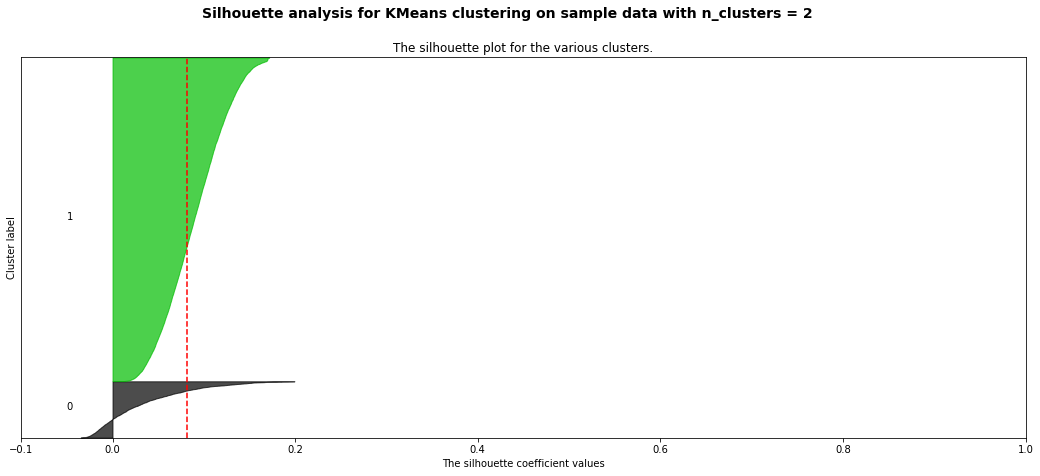

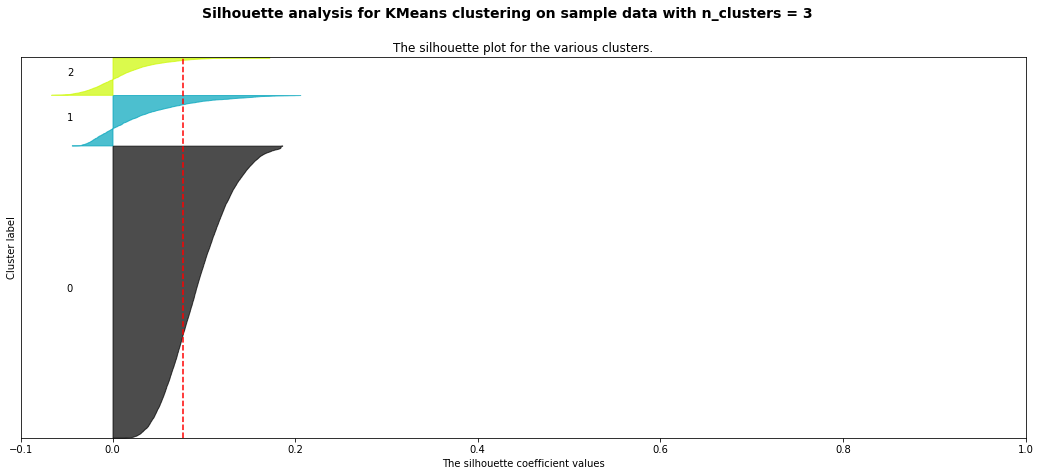

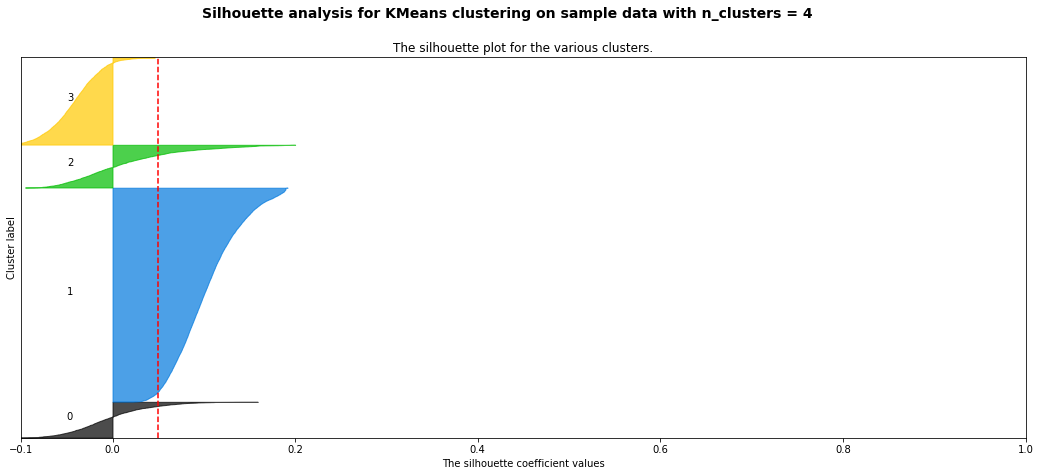

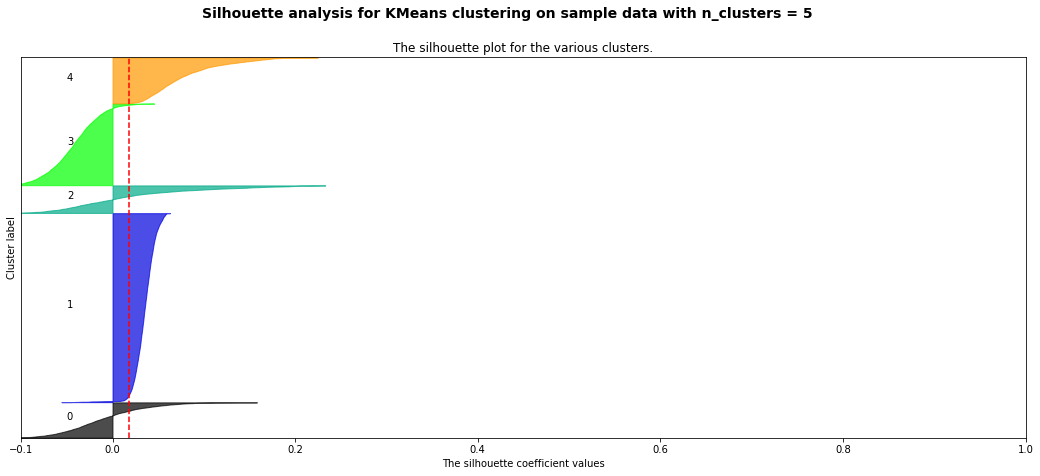

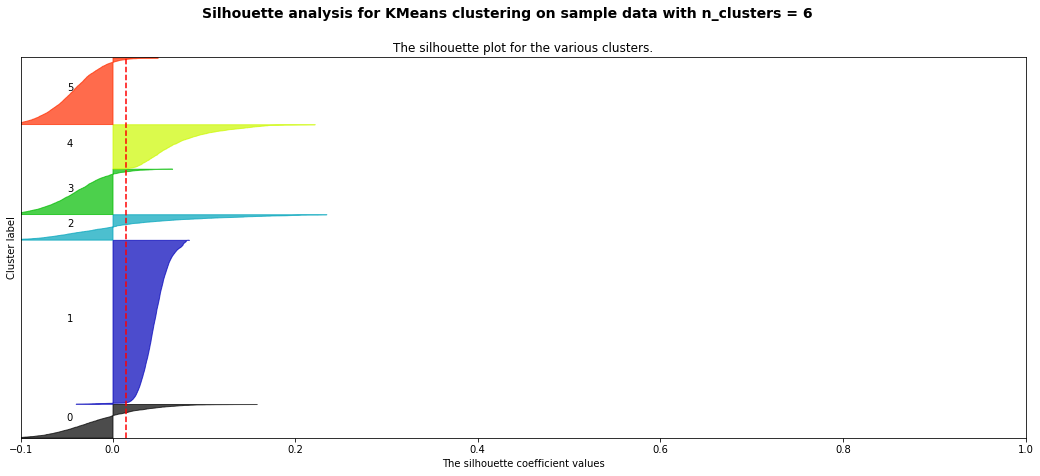

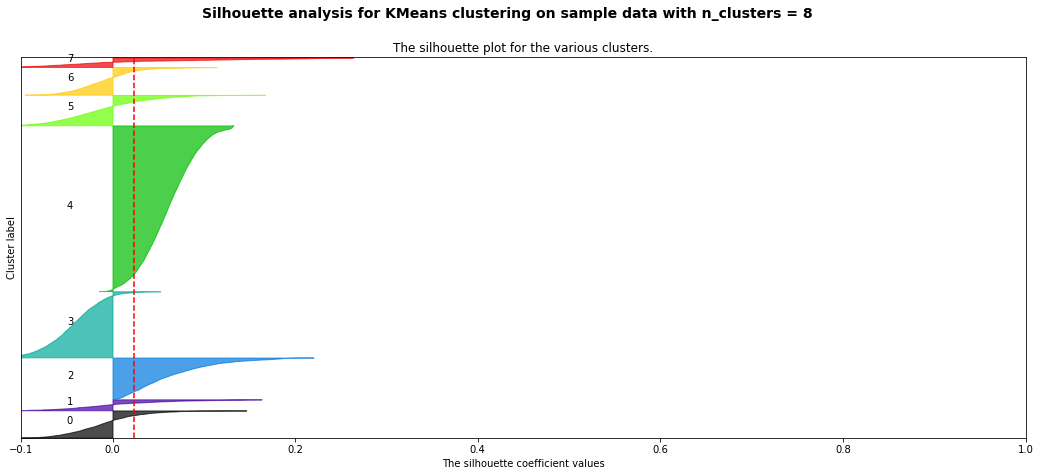

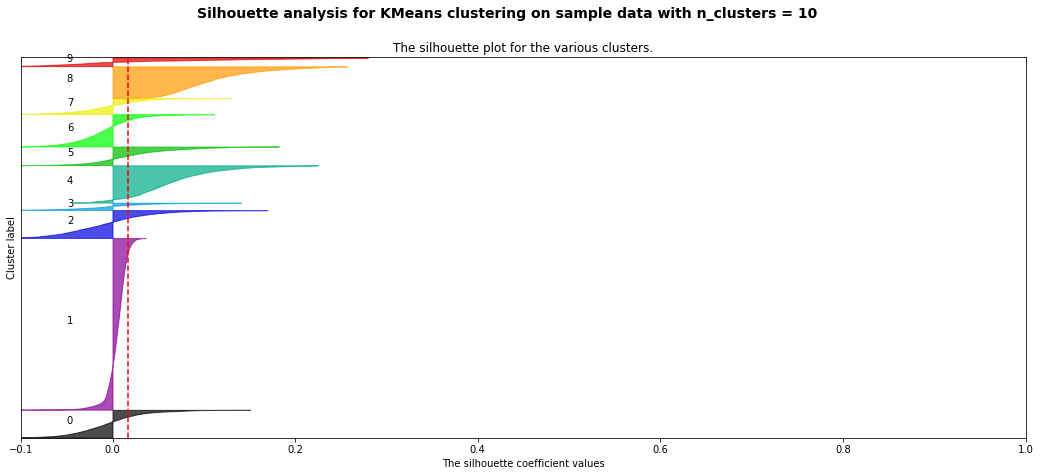

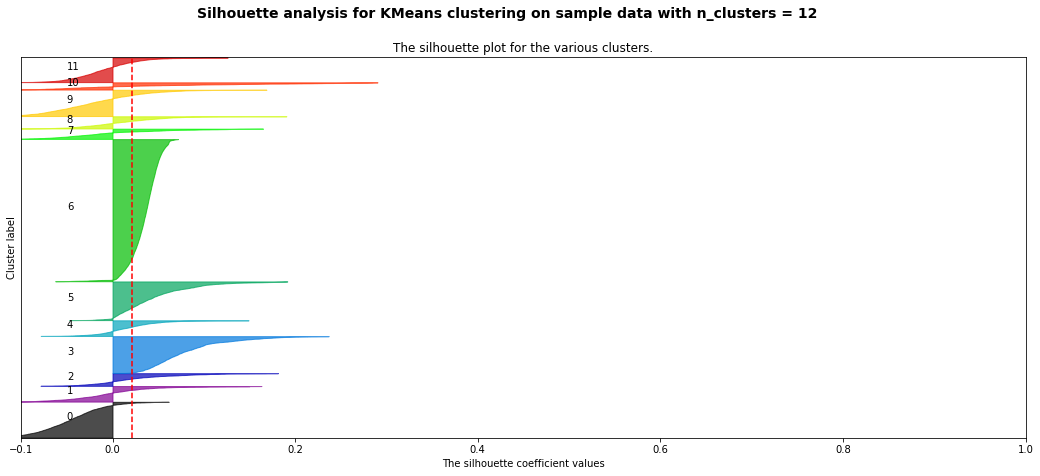

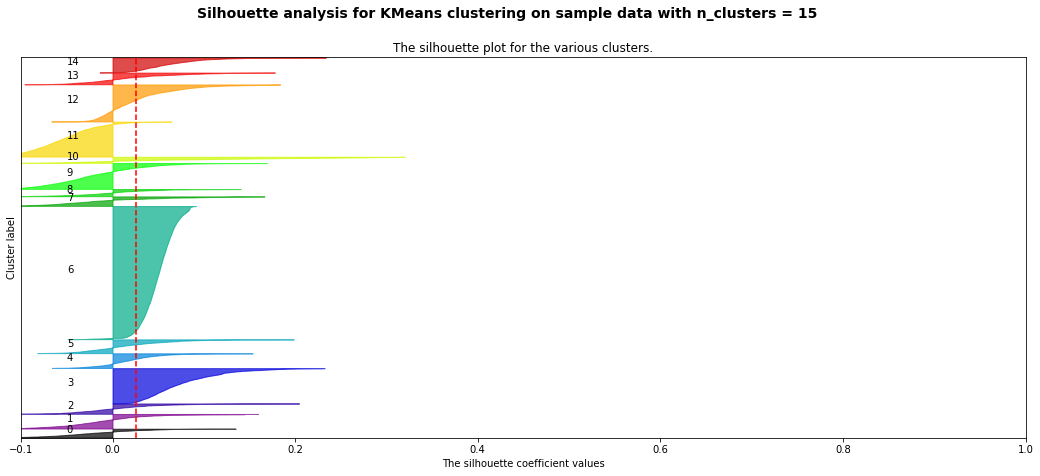

In [34]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm

range_n_clusters = [2, 3, 4, 5, 6, 8, 10, 12, 15]

for n_clusters in range_n_clusters:
    fig = plt.figure(figsize=(18, 7))
    ax = plt.axes()
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])
    
    model = KMeans(n_clusters=n_clusters, n_jobs=4, random_state=42)
    cluster_labels = model.fit_predict(reduced_data)

    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

Видно, что KMeans всё равно оставляет крупный кластер (> 50% выборки) и метрика силуэта смещена в сторону большего кластера.

## Hierarchy

### A. Визуально смотреть, насколько тексты в одном кластере похожи друг на друга и не похожи на другие. Для этого построить словарь самых частых слов.

In [35]:
def SampleHierarchy(n_clusters, most_common, n_samples, random_state):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(reduced_data)
    for label in range(n_clusters):
        print(f'CLUSTER {label}:')
        print(f'{sum(labels == label)} samples')
        top_words = Counter(np.concatenate(reduced_texts_processed[labels == label].str.split(" ").values)).most_common(most_common + len(stop_words))
        top_words = [word for (word, count) in top_words if word not in stop_words]
        print(f'Most common words: {" ".join(top_words[:most_common])}')
        print('Sample tweets:')
        print()
        for text in reduced_texts[labels == label].sample(n_samples, random_state=random_state):
            print('==================================================')
            print(text)
            print('==================================================')
            print()

Для иерархической кластеризации также имеет место выделение ретвитов

In [36]:
SampleHierarchy(2, 20, 5, 42)

CLUSTER 0:
19631 samples
Most common words: . USERNAME rt URL это день весь хотеть сегодня мочь очень просто знать год человек любить завтра свой новый хороший
Sample tweets:

Похоже, я ещё не скоро удалю ISO с Microsoft Visual Studio. На нём рейтинг на торрентс.сру хорошо растёт %).

@tdsov Отличное сравнение, если бы еще не "на Украине", а "в"...)))

Скучаю по Кате( а она редко пишет, в скайпе уже больше месяца не болтали((ОБИДАА

RT @feveqysofexi: Ужасно, когда лучшая подруга предала!=(((

RT @Kate_Unagi: @kekc_TOMLINSON все заметано:) пиши адресс:D

CLUSTER 1:
369 samples
Most common words: USERNAME rt . это URL ненавидеть ретвлять пробка твит спасибо пойти ахи привет дело читать забывать печаль наш самый тяжелый
Sample tweets:

RT @AlikaNeva: @katrrinalove @kalinkinaluda @marinamashkalev @yuliapolykova Да будет так) спасибо)

RT @Goolyboglazayaa: кто не загадал делание в 14:15, лох)

@F_U_N_G_H_O_U_L @jopa_opa @Angelika_Storm @Lavrina0906 @piki_tavi_way спосибо тебе)))ты ахуенный)

In [37]:
SampleHierarchy(10, 20, 5, 42)

CLUSTER 0:
671 samples
Most common words: . USERNAME rt это URL мочь весь хотеть сегодня свой знать сказать самый день ахах нравиться мама забывать вообще год
Sample tweets:

проснулась изза того,что приснился Пономарёв)ахах)вспомнила,что у него сегодня др)поздравляю его от всей души)

RT @distortedpain_: но она все равно сдохла ((

вчера со своим мужиком марафонили Мастера и Маргариту. Он впечатлился). У меня снова жбан с харчо и мешки мандаринов.

@karenadamyan27 @ZigZagMakryak он его оставит на память))

@ktullanux Ага, так и говрил: Нахуй она нужна? Ради дырки чтоль её терпеть? :)))))

CLUSTER 1:
15029 samples
Most common words: . USERNAME rt URL это весь сегодня мочь очень просто день знать хотеть человек свой вообще любить хороший понимать самый
Sample tweets:

ааарр как же мне нравится жить в собственном доме!!))))

@GrAxamentov ага( все говорят что очень больно даже под анестезию, но выбора у меня нет, так что придется потерпеть

Эхх..влюблённые глаза не замечают того,что проис

### B. Воспользоваться метрикой силуэта

For n_clusters = 2 The average silhouette_score is : 0.15438435058463074
For n_clusters = 3 The average silhouette_score is : 0.1045060779483517
For n_clusters = 4 The average silhouette_score is : 0.09014224046261646
For n_clusters = 5 The average silhouette_score is : 0.07882943994687032
For n_clusters = 6 The average silhouette_score is : 0.07826326381618334
For n_clusters = 8 The average silhouette_score is : -0.07240659630409682
For n_clusters = 10 The average silhouette_score is : -0.06696679073870791
For n_clusters = 12 The average silhouette_score is : -0.06219669149794669
For n_clusters = 15 The average silhouette_score is : -0.056483536370525396


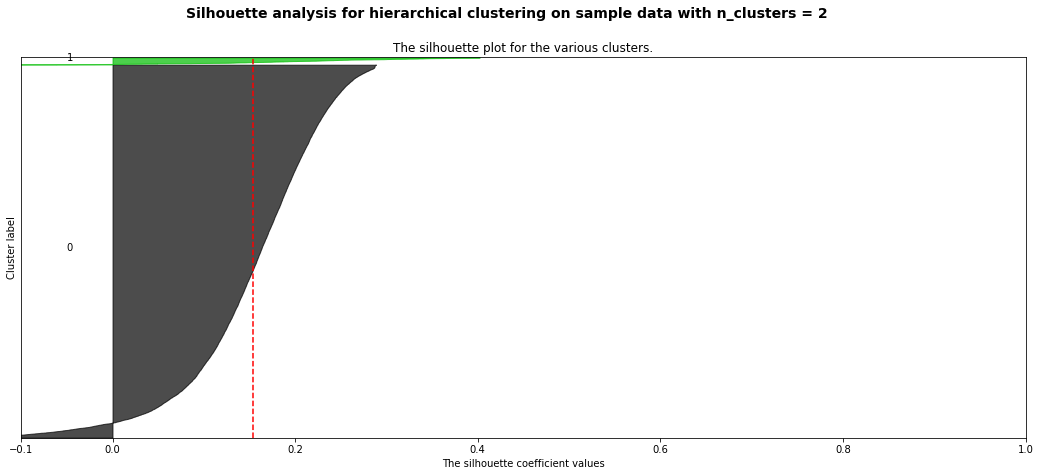

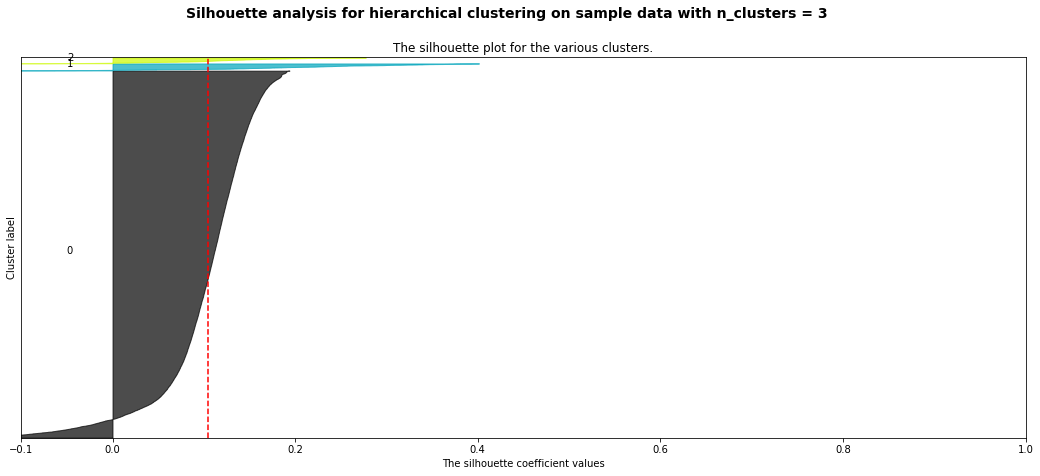

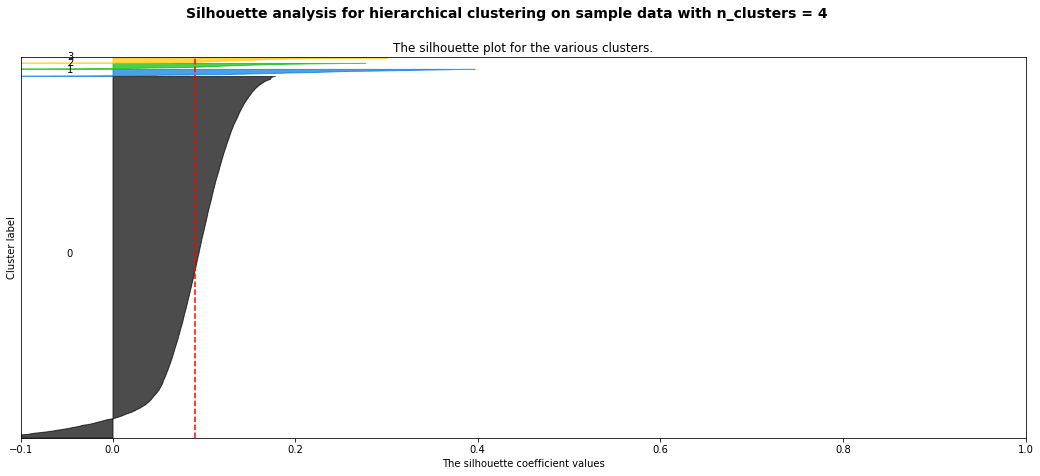

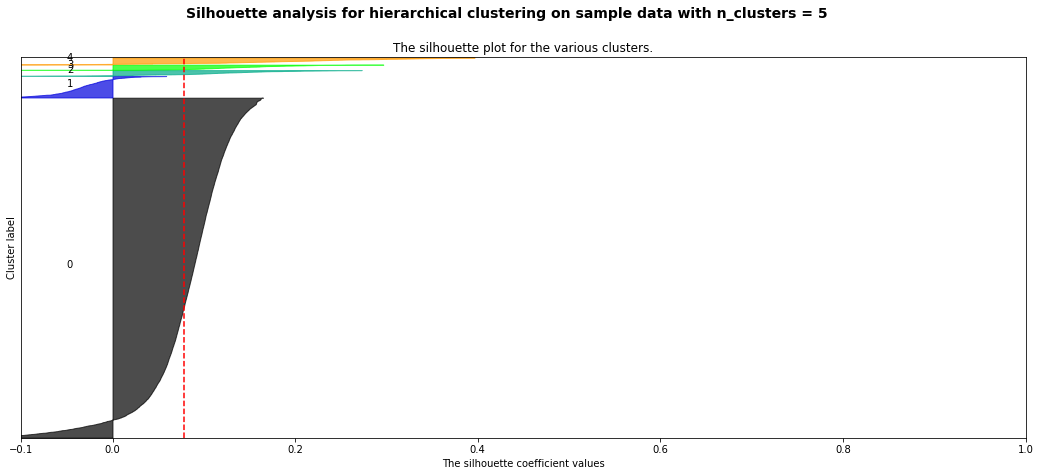

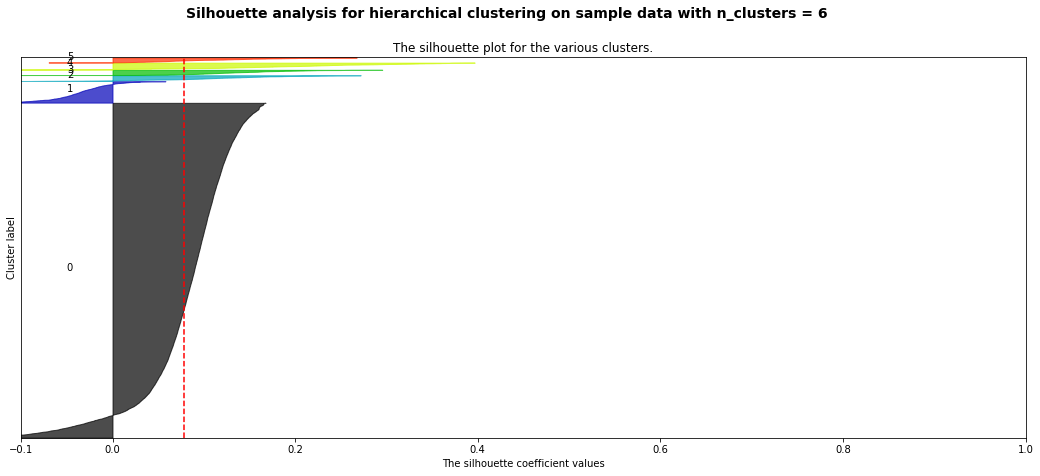

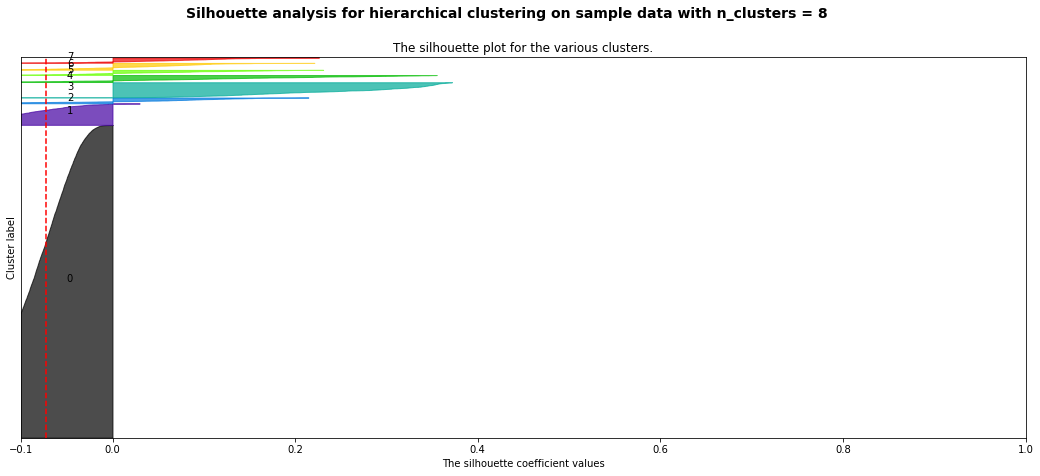

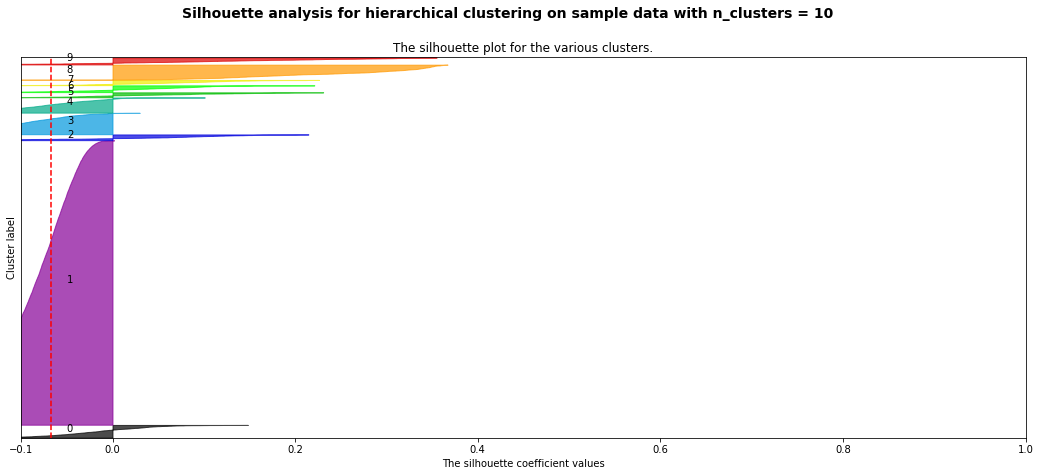

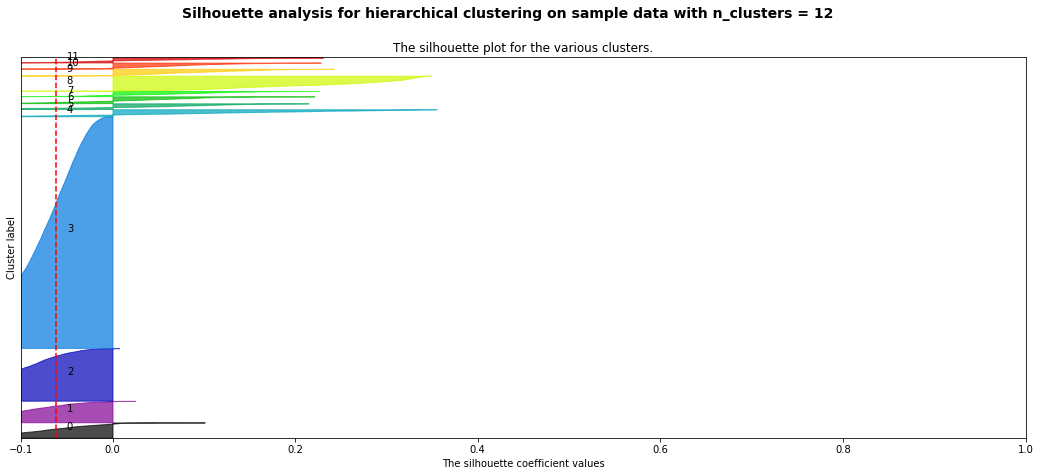

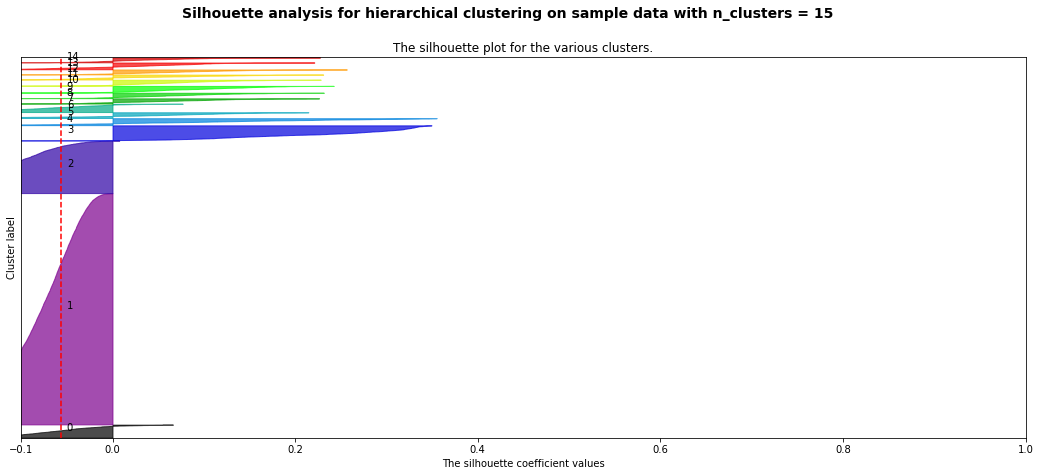

In [38]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm

range_n_clusters = [2, 3, 4, 5, 6, 8, 10, 12, 15]

for n_clusters in range_n_clusters:
    fig = plt.figure(figsize=(18, 7))
    ax = plt.axes()
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])
    
    model = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = model.fit_predict(reduced_data)

    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    plt.suptitle(("Silhouette analysis for hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### C. Посмотреть в каком месте столбцы linkage начинают резко расти

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(reduced_data, 'ward')

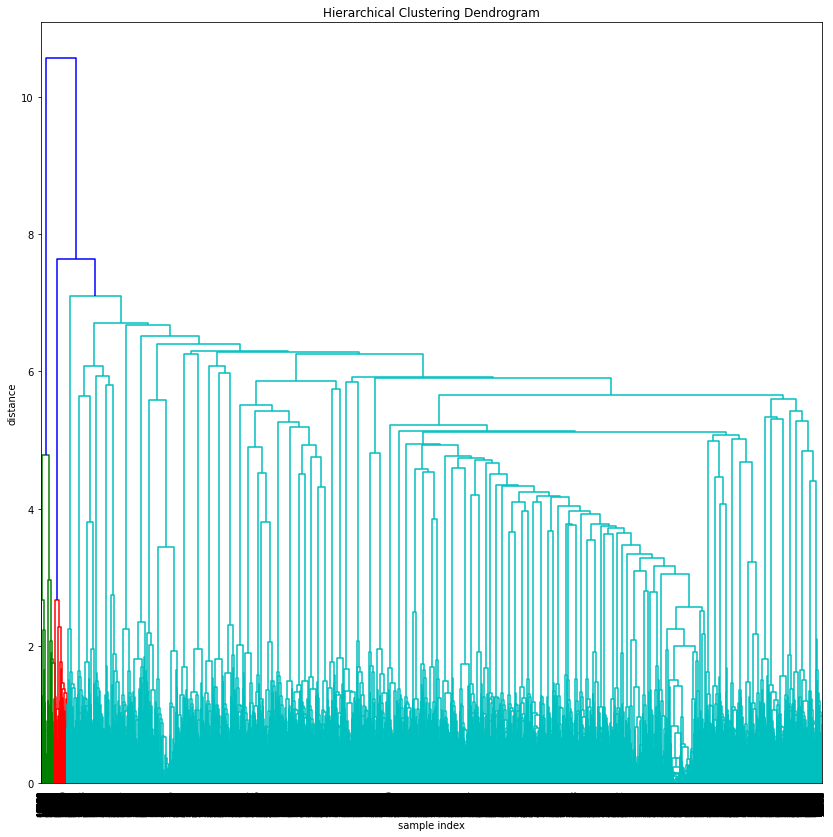

In [40]:
plt.figure(figsize=(14, 14))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
)
plt.show()

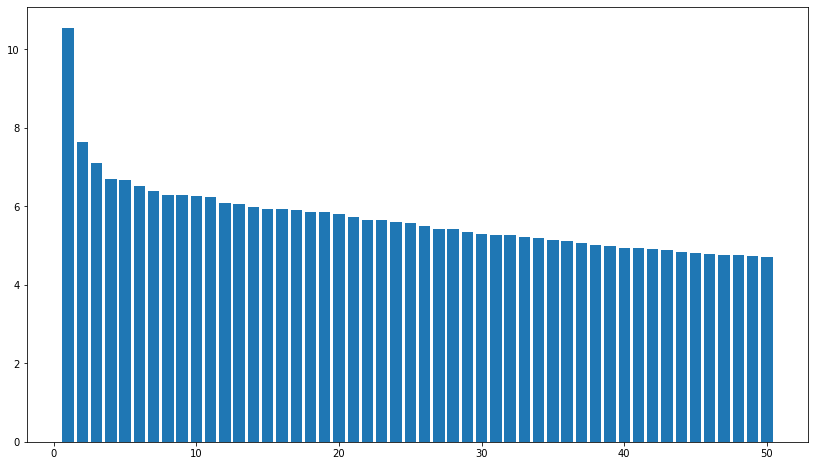

In [41]:
plt.figure(figsize=(14, 8))
plt.bar(range(1, 51), list(reversed(Z[-50:, 2])));

Виден разрыв между 1 и 2, 2 и 3, 3 и 4, 5 и 6, 6 и 7, 7 и 8, 11 и 12 кластерами

## EM-algorithm / GaussianMixture

### A. Визуально смотреть, насколько тексты в одном кластере похожи друг на друга и не похожи на другие. Для этого построить словарь самых частых слов.

In [42]:
def SampleEM(n_clusters, most_common, n_samples, random_state):
    model = GaussianMixture(n_components=n_clusters)
    model.fit(reduced_data)
    labels = model.predict(svd.transform(data))
    for label in range(n_clusters):
        print(f'CLUSTER {label}:')
        print(f'{sum(labels == label)} samples')
        top_words = Counter(np.concatenate(processed_texts[labels == label].str.split(" ").values)).most_common(most_common + len(stop_words))
        top_words = [word for (word, count) in top_words if word not in stop_words]
        print(f'Most common words: {" ".join(top_words[:most_common])}')
        print('Sample tweets:')
        print()
        for text in texts[labels == label].sample(n_samples, random_state=random_state):
            print('==================================================')
            print(text)
            print('==================================================')
            print()

Для смеси распределений характерны примерно одинаковые размеры кластеров, ретвиты не выделяются в отдельный кластер, однако большая часть ретвитов сосредоточена в нулевом кластере

In [43]:
SampleEM(2, 20, 5, 42)

CLUSTER 0:
97464 samples
Most common words: . USERNAME rt URL это день хотеть весь сегодня очень год просто спасибо любить новый хороший знать завтра самый утро
Sample tweets:

RT @PolishaV: А я все еще грущу, что Антоши Беляева нет в голосе :( #голос

@ElenaZev Да, долги - вещь неприемлемая! Очень ответственно отношусь к любым обязательным платежам. Но в долг или кредит никогда, ни ногой))

@serovanata проехал. В итоге только автобус кока-колы у меня на видео. :(

RT @VadimKyrilenko: @1your_Mars @Vkarburos Ахааха,у меня частный сектор,тут очень весело :D

@dashka_kaza ещё счка меня заставляет обновлять :DD

CLUSTER 1:
129370 samples
Most common words: . USERNAME rt URL это мочь весь хотеть день человек свой сегодня знать очень делать понимать просто спать блин почему
Sample tweets:

@9910917v пупсик, мест нет, я же не пойду пешком(

Лучше, нет больше никакой зависимости, трата нервов, издевательство, унижения)

спасите меня от тех уродов которые пишут,что хотят заняться со мной сексом

In [44]:
SampleEM(10, 20, 5, 42)

CLUSTER 0:
19888 samples
Most common words: . USERNAME спасибо rt это URL день знать человек друг любить весь понимать свой хотеть сказать просто хороший сегодня очень
Sample tweets:

@TheAdamova_Eva 
завтра посмотрю )
сегодня уже не получится, спасибо :)

Сегодня мне везет) 
Стою в гардеробе, говорю Марине:" вот бы мне дали номерок с тремя семерками
ахах,  смотрю-несет:D http://t.co/6DEnUWMTgn

RT @syfubotiweb: вот и кто еще может находясь дома расшибить себе бровь дверью шкафа!!!! ауч(((((

а ещё каждый раз в автобусе в кого нибудь влюбляюсь,а потом когда она выходит она разбивает мне сердце(

А вы знаете,я 14 февраля отмечаю не одна,а с любимым человечком..моей подругой) #RU_FF

CLUSTER 1:
16142 samples
Most common words: . USERNAME rt это URL очень хотеть сказать мочь болеть говорить просто весь человек ничто мама плохо голова нравиться смотреть
Sample tweets:

мужчина посмотрел в мой рот и сказал, что там риальне живет ангина. тваю ж мать :)

RT @xTPExPA3_DBAx: @trekulovich да так

19822 samples
Most common words: . USERNAME rt это любить URL понимать знать человек друг хороший просто очень хотеть сказать весь самый давать почему мочь
Sample tweets:

Иногда думаешь, что ты нужен многим, а попадаешь в неприятности и понимаешь, что у тебя никого и нет(

Мы растаемся любя...не наша в том вина!!!Любовь всегда права!!!(

AAAW!!! МНЕ НРАВИТСЯ МОЙ ГОЛОС СЕЙЧАС! НЕМНОГО ХРИПЛЫЙ И Я КАРОЧ ВЛЮБИЛСЯ В СВОЙ ГОЛОС...но как выздоровею, такого голоса больше не будет(((

Была на заброшке которой уже нет(((печально конечно то что её снесли

Каким же непривычным стало чувство холода :-) сейчас вроде прохладно на улице, но после вчерашней жары...

CLUSTER 9:
25673 samples
Most common words: . USERNAME rt URL день это весь год сегодня самый свой думать новый жизнь мочь который любимый скучать завтра последний
Sample tweets:

@NastyaExotic я Лу за это и обожаю )) за его вечно упоротый вид и то как он ржачно всегда угорает ))

Эти люди,что то скрывают от меня.И меня это крайне настора

### B. Воспользоваться метрикой силуэта

For n_clusters = 2 The average silhouette_score is : 0.009178029054939592
For n_clusters = 3 The average silhouette_score is : -0.034847169311301274
For n_clusters = 4 The average silhouette_score is : -0.04955447305028215
For n_clusters = 5 The average silhouette_score is : -0.05088995767318803
For n_clusters = 6 The average silhouette_score is : -0.06445129777498915
For n_clusters = 8 The average silhouette_score is : -0.08799987881167357
For n_clusters = 10 The average silhouette_score is : -0.10315675935824502
For n_clusters = 12 The average silhouette_score is : -0.10933169571172413
For n_clusters = 15 The average silhouette_score is : -0.08780709729500359


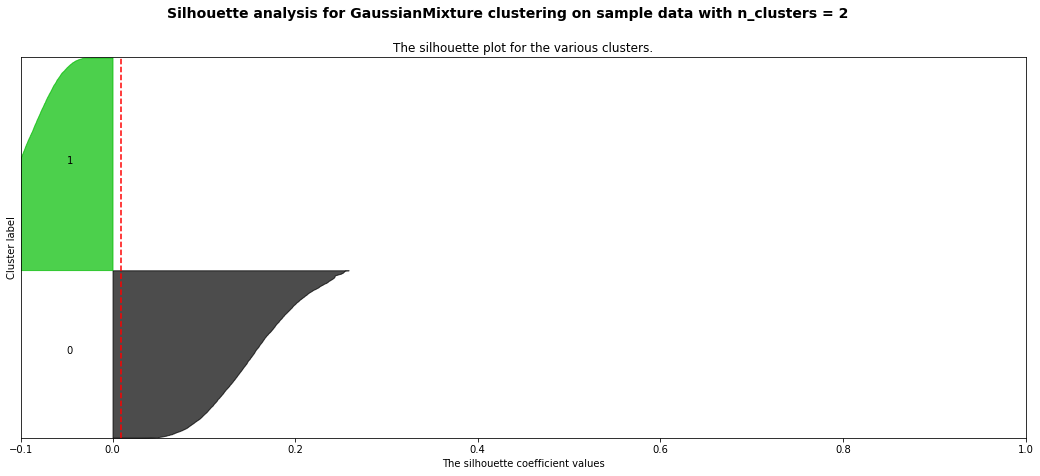

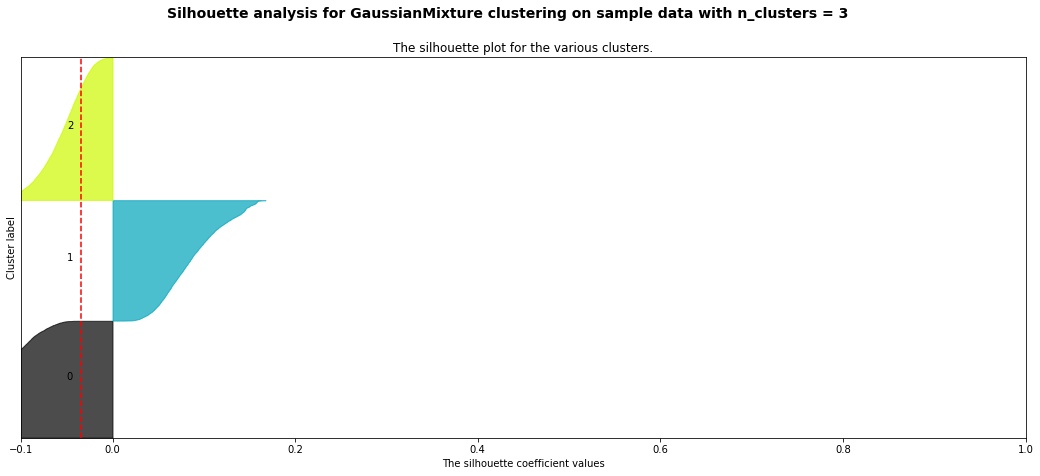

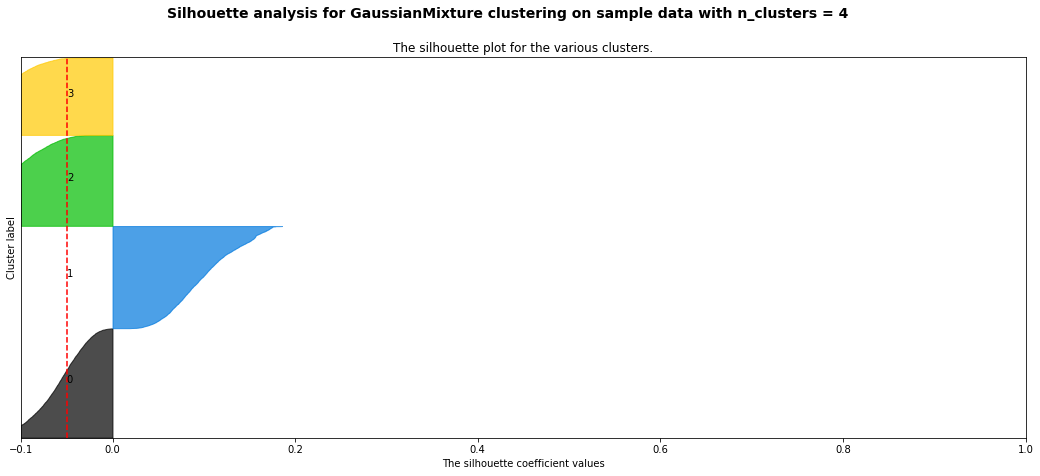

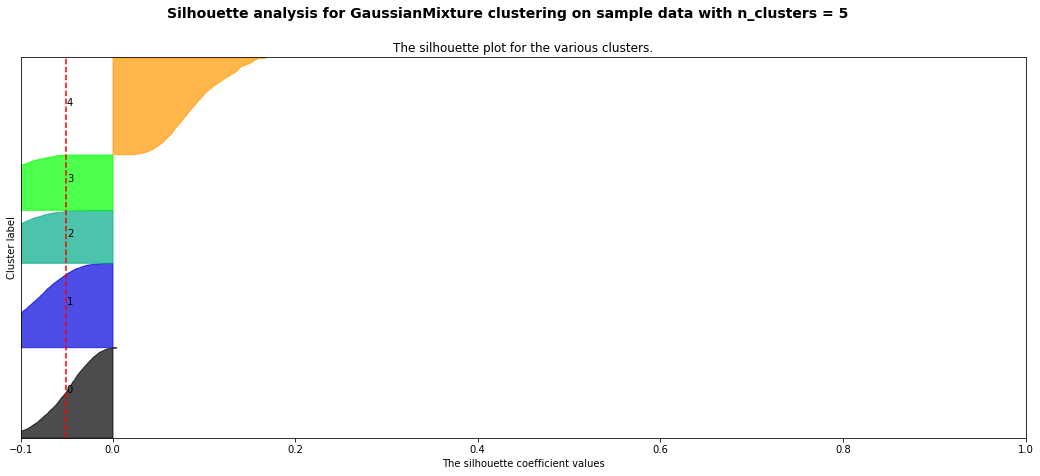

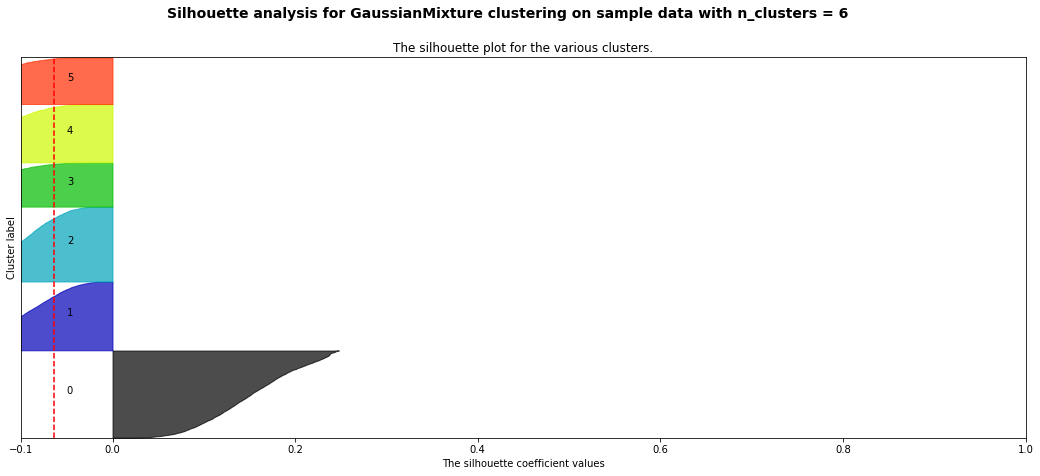

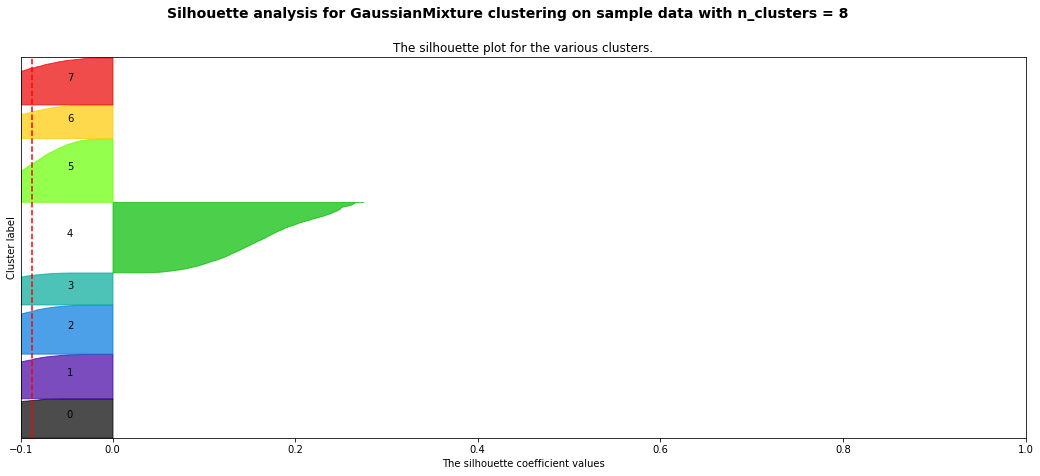

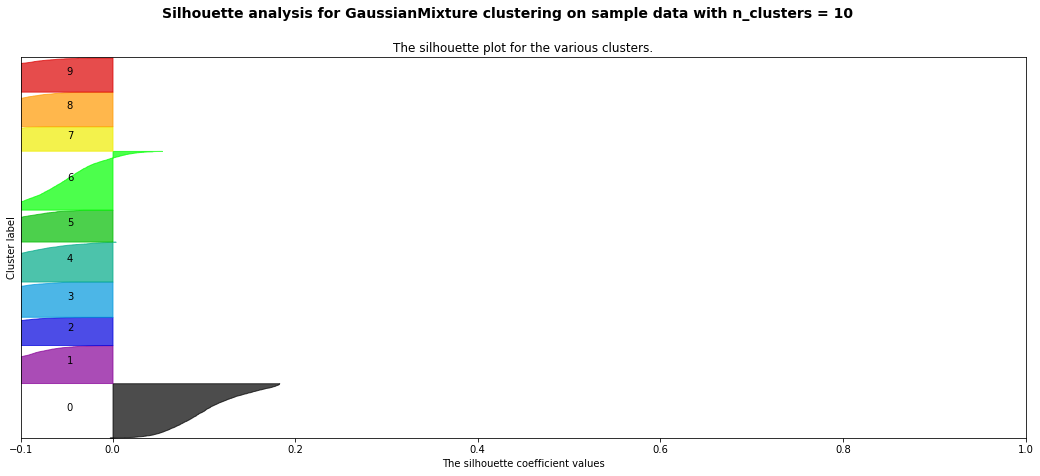

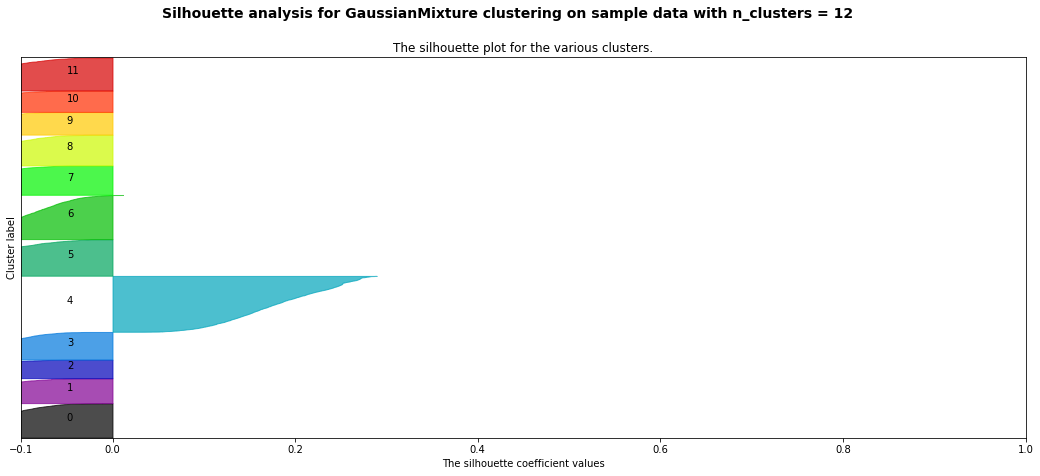

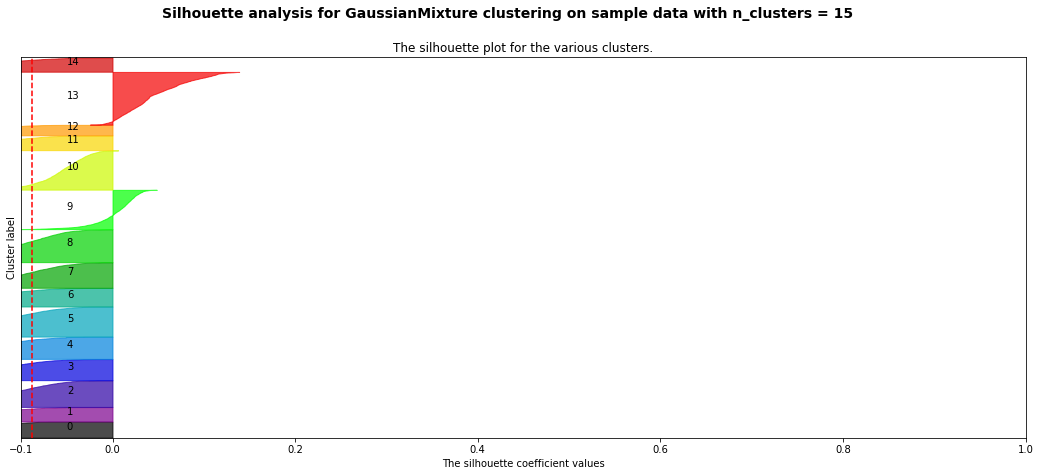

In [45]:
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm

range_n_clusters = [2, 3, 4, 5, 6, 8, 10, 12, 15]

for n_clusters in range_n_clusters:
    fig = plt.figure(figsize=(18, 7))
    ax = plt.axes()
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])
    
    model = GaussianMixture(n_components=n_clusters)
    cluster_labels = model.fit_predict(reduced_data)

    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

    plt.suptitle(("Silhouette analysis for GaussianMixture clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# 4. Дополнительно для linkage посмотреть структуры кластеров от 1 до 10 и попытаться понять, есть ли в этом логика :)

Структура кластеров:
0. В основном, негативные твиты
1. Всё подряд - самый большой кластер с >75% выборки
2. Новый год, даты, положительные твиты
3. Твиты, связанные с датами
4. Твиты-желания
5. Твиты-желания
6. В основном, положительные твиты
7. Спасибо
8. Ретвиты / твиты со ссылками
9. В основном, негативные ретвиты

In [46]:
SampleHierarchy(10, 20, 10, 42)

CLUSTER 0:
671 samples
Most common words: . USERNAME rt это URL мочь весь хотеть сегодня свой знать сказать самый день ахах нравиться мама забывать вообще год
Sample tweets:

проснулась изза того,что приснился Пономарёв)ахах)вспомнила,что у него сегодня др)поздравляю его от всей души)

RT @distortedpain_: но она все равно сдохла ((

вчера со своим мужиком марафонили Мастера и Маргариту. Он впечатлился). У меня снова жбан с харчо и мешки мандаринов.

@karenadamyan27 @ZigZagMakryak он его оставит на память))

@ktullanux Ага, так и говрил: Нахуй она нужна? Ради дырки чтоль её терпеть? :)))))

@grinchikanna1 А он серьёзно ногу сломал?(

@ismagilovaanast я тоже плачу((( Он заслужил:3 он умницааа :3

Кстати, @RubyRoid подарил мне инвайт на лепру, а я забыл ему позвонить и поблагодарить. Вставьте мне пизды, пожалуйста. Я ёбаный слоупок.Ж(

Похоже, я ещё не скоро удалю ISO с Microsoft Visual Studio. На нём рейтинг на торрентс.сру хорошо растёт %).

“@rianru: Тетя лидера КНДР Ким Чен Ына, возмо

276 samples
Most common words: спасибо USERNAME . rt URL это большой очень приятно день весь настроение ахах вечер дорогой хороший поздравлять поздравление любить время
Sample tweets:

@150LF @_Do_or_Die__ @kl20004 @Jane_1Di @mashushnik @Hazz____ @Helen_boom @1DYulia1D @MaryShch спасибо *-* и тебя с:

Спасибо @NmouseB за то, что подняла мне настроение:)

всем спасибо за поздравления. 
приятно если честно. :*

RT @Sonek_22: И тебе чудо.спасибо за поддержку:)))) без твоей теплоты я бы тоже не сдала зачеты:*))) @timakova01

это все-таки так приятно - слышать "спасибо Вам! здоровья, любви и удачи!", когда степень кипения мозга достигает предела)

Настроение прям поднимается, когда смотрю на все сегодняшние фооотки)) спасибо Крис

Все,что происходит - к лучшему. Набираюсь настроя и иду дальше. Спасибо сэнсэю)

Безумно классно выступила рок-н-ролл группа "Big boss") атмосфера потрясающая)) спасибо @Mr.Boo

Такая милая на фотке:) — Спасибо ^_^ http://t.co/vP4m0AorUy

Спасибо @EuropaPlus! Буде